# **EKF Simulation**
In questo notebook implementeremo un ESEKF (Error State Extended Kalman Filter) avanzato con tecniche di correzione del coning, sculling delayed state.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib
import visualizer.plot as visualizer

import utilities as tools
import circularBuffer

## Utilities

### LPF 1 ordine esponenziale

$$\alpha = exp(-\frac{2\pi f_c}{f_s})$$

$$y_k = \alpha y_{k-1} + (1 - \alpha)x_k$$

In [2]:
def calculate_alpha(fc, fs):  #fc = cutoff frequency | fs = sample frequency
    return math.exp(-((2*math.pi*fc) / (fs)))

def lpfFirstOrderExp(x, y_prev, alpha):    #x = new measure
    y = alpha * y_prev + (1 - alpha) * x
    lpfFirstOrderExp.y_prev = y

    return y

### LPF 2 ordine butterworth
$$y_k = b_0 x_k + b_1 x_{k-1} + b_2 x_{k-2} - a_1 y_{y-1} - a_2 y_{k-2}$$

### Coning Compensation

$$\Delta\theta _{k} = \omega dt$$
$$\Delta\theta _{corr} = \Delta\theta _{k-1} + \Delta\theta _{k} + \frac{1}{12}(\Delta\theta _{k-1} \times \Delta\theta _{k} )$$

In [3]:
def coning_compensation(omega, dtheta_prev, dt):
    dtheta = omega * dt

    return dtheta_prev + dtheta + 1/12*(np.cross(dtheta_prev, dtheta))

### Sculling Compensation


$$\Delta v_{k} = a dt$$
$$\Delta v_{corr} = \Delta v_{k-1} + \Delta v_{k} + \frac{1}{2}(\Delta\theta _{k-1} \times \Delta v_{k} ) + \frac{1}{12}(\Delta\theta _{k-1} \times \Delta v_{k-1} )$$

In [4]:
def sculling_compensation(acc, dv_prev, dtheta_prev, dt):
    dv = acc * dt

    return dv_prev + dv + 1/2*np.cross(dtheta_prev, dv) + 1/12*np.cross(dtheta_prev, dv_prev)

## EKF

$$\delta X = [\delta\theta, \delta p, \delta v, \delta b_g, \delta b_a ]   $$
$$\delta X ∈ ℝ^{15}

In [5]:
x_0 = np.array([1,0,0,0, 0,0,0, 0,0,0, 0,0,0, 0,0,0]).transpose()    # STATI NOMINALI ->  p[3] v[3] q[4] b_g[3] b_a[3]  forse-> earth magnetic field[3] body magnetic field [3]

delta_x_0 = np.array([0,0,0, 0,0,0, 0,0,0, 0,0,0, 0,0,0]).transpose()      #error states ->delta_pos[3], delta_vel[3],  delta_theta[3] (non si linearizzano i quaternioni)  delta_b_g[3] , delta_b_a[3]


g = 9.81





In [6]:


class EKF:
    def __init__(self, dt):
        
        sigma_acc = 0.03      # m/s^2 / sqrt(Hz)
        sigma_gyro = 0.001    # rad/s / sqrt(Hz)
        sigma_ba = 0.0001     # m/s^2 / sqrt(Hz)
        sigma_bg = 1e-6       # rad/s / sqrt(Hz)

        self.Q = np.diag([
            sigma_acc**2, sigma_acc**2, sigma_acc**2,       # accelerometro
            sigma_gyro**2, sigma_gyro**2, sigma_gyro**2,    # giroscopio
            sigma_ba**2, sigma_ba**2, sigma_ba**2,          # bias accel
            sigma_bg**2, sigma_bg**2, sigma_bg**2           # bias gyro
        ])

        sigma_gps_pos = 2
        sigma_gps_vel = 0.5
        #matrice di covarianza di misura del GPS
        self.R_gps = np.diag([
            sigma_gps_pos**2,sigma_gps_pos**2,sigma_gps_pos**2,
            sigma_gps_vel**2,sigma_gps_vel**2,sigma_gps_vel**2
        ])

        self.buffer_state = circularBuffer.CircularBuffer(math.ceil(1/2*dt))  #buffer per delayed state

        #Si inserisce il primo elemento del buffer
        t = 0 #timestamp
        x = np.array([0,0,0, 0,0,0, 1,0,0,0, 0,0,0, 0,0,0]).transpose() 
        P = np.zeros((15,15))

        self.buffer_state.add({
            "timestamp": t,
            "x_nominal": x.copy(),
            "P": P.copy(),
            "delta_theta_corr": np.array([0,0,0]).transpose(),
            "delta_vel_corr": np.array([0,0,0]).transpose(),
            "acc": np.array([0,0,0]).transpose(),
            "omega": np.array([0,0,0]).transpose()
        })

        self.propagation_step = 5   # Numero di propagazioni per ogni fase di predict
        self.propagation_index = 0  # indice del buffer a cui è arrivata la propagazione 
        self.propagation = False    # flag che indica se bisogna effettuare la propagazione

        self.log = {
            "t": [],
            "nominal_pos": [],
            "nominal_vel": [],
            "nominal_euler": [],
            "error_pos": [],
            "error_vel": [],
            "error_att": [],
            "error_ba": [],
            "error_bg": [],
            "Pdiag": [],
            "innov_gps_pos": [],
            "innov_gps_vel": [],
            "imu_acc": [],
            "imu_gyro": [],
            "delay_latency": [],
            "delay_index": [],
        }


    def _jacobians_error_state(self, q, a, w, dt):
        """
        Restituisce F e G dell’error-state EKF2 di PX4.
        q : quaternion [qw, qx, qy, qz]
        a : accelero (bias corrected) in body frame
        w : gyro (bias corrected) in body frame
        dt: timestep
        """

        # --- rotation matrix ---
        R = tools.rotmat_body_to_ned(q)

        # Numero stati errore PX4
        n = 15

        # Matrici
        F = np.zeros((n, n))
        G = np.zeros((n, 12))   # rumori: accel, gyro, bias_a, bias_g

        # ---------------------------------------------------------
        # BLOCCO POSIZIONE
        # δp_dot = δv
        # ---------------------------------------------------------
        F[0:3, 3:6] = np.eye(3)

        # ---------------------------------------------------------
        # BLOCCO VELOCITÀ
        # δv_dot = -R[a]_× δθ  - R δb_a  + R n_a
        # ---------------------------------------------------------
        F[3:6, 6:9] = -R @ tools.skew(a)
        F[3:6, 9:12] = -R

        # rumore accelerometro
        G[3:6, 0:3] = R

        # ---------------------------------------------------------
        # BLOCCO ORIENTAZIONE
        # δθ_dot = -[ω]_× δθ - δb_g + n_g
        # ---------------------------------------------------------
        F[6:9, 6:9] = -tools.skew(w)
        F[6:9, 12:15] = -np.eye(3)

        # rumore gyro
        G[6:9, 3:6] = np.eye(3)

        # ---------------------------------------------------------
        # BLOCCO BIAS ACCELERO
        # δb_a_dot = n_ba
        # ---------------------------------------------------------
        # modello: random walk → F = 0, G = I * sigma
        G[9:12, 6:9] = np.eye(3)

        # ---------------------------------------------------------
        # BLOCCO BIAS GIRO
        # δb_g_dot = n_bg
        # ---------------------------------------------------------
        G[12:15, 9:12] = np.eye(3)

        # ---------------------------------------------------------
        # BLOCCO VENTO in PX4:
        # δw_dot = 0 (stato costante)
        # ---------------------------------------------------------
        # Nessuna dinamica → tutte le Jacobiane restano 0

        # ---------------------------------------------------------
        # Discretizzazione: Φ = I + F * dt
        # ---------------------------------------------------------
        Phi = np.eye(n) + F * dt

        # Noise discretization: Gd = G * dt
        Gd = G * dt

        return Phi, Gd, F, G
    
    def _predict_nominal_states(self, x_prev, delta_theta_corr, delta_vel_corr, dt):
        #Stima stati nominali
        x = x_prev.copy()

        q_prev = x_prev[6:10].ravel()
        dq = tools.quat_from_small_angle(np.asarray(delta_theta_corr).ravel())
        
        q_new = tools.quat_multiply(dq, q_prev)
        if np.linalg.norm(q_new) < 1e-12:
            q_new = np.array([1,0,0,0])
        else:
            q_new = q_new / np.linalg.norm(q_new)

        x[6:10] = q_new

        x[3:6] = x_prev[3:6] + (tools.rotmat_body_to_ned(x[6:10]) @ np.asarray(delta_vel_corr).ravel())
        x[0:3] = x_prev[0:3] + x[3:6] * dt

        x[10:13] = x_prev[10:13] + np.random.normal(scale=1e-6, size=3) * np.sqrt(dt)
        x[13:16] = x_prev[13:16] + np.random.normal(scale=1e-7, size=3) * np.sqrt(dt)

        return x
    
    #funzione che manda avanti la propagazione
    def _propagation(self, dt):
        step = 0
        while self.propagation and step < self.propagation_step:
            if self.propagation_index < 0 or self.propagation_index >= len(self.buffer_state.buffer):
                #non c'è più niente da propagare
                self.propagation = False
                break

            prev_elem = self.buffer_state.get(self.propagation_index - 1)
            cur_elem = self.buffer_state.get(self.propagation_index)

            x_nominal = np.asarray(cur_elem['x_nominal']).ravel()
            delta_theta = np.asarray(cur_elem['delta_theta_corr']).ravel()
            delta_vel = np.asarray(cur_elem['delta_vel_corr']).ravel()
            acc = np.asarray(cur_elem['acc']).ravel()
            omega = np.asarray(cur_elem['omega']).ravel()

            prev_x_nominal = np.asarray(prev_elem['x_nominal']).ravel()

            x_propagated = self._predict_nominal_states(prev_x_nominal,delta_theta, delta_vel, dt)

            Phi, Gd, F, G = self._jacobians_error_state(x_nominal[6:10], acc, omega, dt)

            # propaga covarianza partendo dalla P salvata in prev_elem
            P_propagated = Phi @ prev_elem['P'] @ Phi.T + Gd @ self.Q @ Gd.T

            self.buffer_state.update(self.propagation_index, {
                "timestamp": cur_elem['timestamp'],
                "x_nominal": x_propagated.copy(),
                "P": P_propagated.copy(),
                "delta_theta_corr": cur_elem['delta_theta_corr'],
                "delta_vel_corr": cur_elem['delta_vel_corr'],
                "acc": cur_elem['acc'],
                "omega": cur_elem['omega']
            })

            self.propagation_index += 1
            step += 1
        
        # se abbiamo raggiunto la fine, disabilitiamo
        if self.propagation_index >= len(self.buffer_state.buffer):
            self.propagation = False



    def predict(self, gyro_meas, acc_meas, dt, t):

        #capire come gestire lo switching atomico     
        prev = self.buffer_state.get()  #si prende l'ultimo elemento del buffer => l'elemento stimato nel predict prima
        #correzione bias
        omega = np.asarray(gyro_meas) - prev["x_nominal"][10:13]
        acc = np.asarray(acc_meas) - prev["x_nominal"][13:16] - np.array([0.0,0.0,9.81])
        #Compensation
        delta_theta_corr = coning_compensation(omega, prev["delta_theta_corr"], dt)
        delta_vel_corr = sculling_compensation(acc, prev["delta_vel_corr"], prev["delta_theta_corr"], dt)

        x = self._predict_nominal_states(prev["x_nominal"], delta_theta_corr, delta_vel_corr, dt)

        self._propagation(dt)

        #Stima error state

        Phi, Gd, F, G = self._jacobians_error_state(x[6:10], acc, omega, dt)

        P = Phi @ prev["P"] @ Phi.T + Gd @ self.Q @ Gd.T

        self.buffer_state.add({
            "timestamp": t,
            "x_nominal": x.copy(),
            "P": P.copy(),
            "delta_theta_corr": delta_theta_corr.copy(),
            "delta_vel_corr": delta_vel_corr.copy(),
            "acc": acc.copy(),
            "omega": omega.copy()
        })

        self.log["t"].append(t)

        x = x.ravel()
        self.log["nominal_pos"].append(x[0:3])
        self.log["nominal_vel"].append(x[3:6])
        self.log["nominal_euler"].append(tools.quat_to_euler(x[6:10]))

        # error state = sempre 0 nel predict
        self.log["error_pos"].append(np.zeros(3))
        self.log["error_vel"].append(np.zeros(3))
        self.log["error_att"].append(np.zeros(3))
        self.log["error_ba"].append(np.zeros(3))
        self.log["error_bg"].append(np.zeros(3))

        self.log["Pdiag"].append(np.diag(P))

        self.log["imu_acc"].append(acc)
        self.log["imu_gyro"].append(omega)

        # INFO PER DELAYED STATE
        self.log["delay_latency"].append(0)  # lo calcoli tu se vuoi
        self.log["delay_index"].append(self.propagation_index)

        return x, P
    
    # gps data -> spostamento rispetto a un punto e velocità nel NED frame
    # {
    #       "timestamp":x,
    #       "meas":pos[3] vel[3]
    #}
    
    def update_GPS(self, gps_data):
        gps_timestamp = gps_data.timestamp
        gps_meas = gps_data.meas
        #trovare elemento nel buffer
        buffer_state_old, index = self.buffer_state.get_by_timestamp(gps_timestamp)

        if buffer_state_old is None:
            return False    # => misura troppo vecchia

        x_nominal_old = buffer_state_old["x_nominal"].ravel()
        P_old = buffer_state_old["P"]

        ##

        innovation = gps_meas - x_nominal_old[0:6]

        H = np.zeros((6,15))
        H[0:3, 0:3] = np.eye(3)
        H[3:6, 3:6] = np.eye(3)

        S = H @ P_old @ H.T + self.R_gps      # matrice dell'innovazione di covarianza S
        K = P_old @ H.T @ np.linalg.inv(S)

        #calcolo delta_x -> correggo lo stato nominale con delta_x -> delta_x = 0

        delta_x = K*innovation

        x_updated = x_nominal_old.copy()
        x_updated[0:6] = x_nominal_old + delta_x[0:6]

        dtheta = delta_x[6:9]
        dq = tools.quat_from_small_angle(dtheta)

        x_updated[6:10] = tools.quat_multiply(dq, x_nominal_old[6:10])

        x_updated[10:13] = x_nominal_old + delta_x[10:13]
        x_updated[13:16] = x_nominal_old + delta_x[13:16]

        P_new = (np.eye(15) - K @ H) @ P_old @ (np.eye(15) - K @ H).T + K @ self.R_gps @ K.T #da cambiare con quella usata da PX4
 
        self.buffer_state.update(index, x_updated.copy(), P_new.copy())

        #mettere indice = indice elemento appena aggiornato + 1
        self.propagation_index = index + 1
        self.propagation = True

        # LOG INNOVATION GPS
        self.log["innov_gps_pos"].append(innovation[0:3])
        self.log["innov_gps_vel"].append(innovation[3:6])


    def update_MAG(self, mag_data):
        pass

## Simulation

[[ 1.54271235e-03  7.17063781e-05 -7.60190650e-04 ...  2.13298615e-03
   1.91591851e-03  1.00028099e-04]
 [-9.63441108e-04 -4.32670034e-04  3.22139528e-04 ... -1.54283260e-03
  -1.35001250e-03 -9.10157325e-04]
 [ 3.34246833e-04  1.04092659e-01  1.04296534e-01 ...  1.06337142e-01
   1.05835793e-01  1.04851012e-01]]
[ 0.00154271 -0.00096344  0.00033425]
[ 7.17063781e-05 -4.32670034e-04  1.04092659e-01]
[-0.00076019  0.00032214  0.10429653]
[-0.0004223  -0.00096112  0.10657452]
[-1.17107645e-05 -1.69429961e-04  1.06493001e-01]
[-0.00034774 -0.00013936  0.10705563]
[0.00065458 0.000977   0.10499929]
[-3.01646277e-05 -8.93205809e-04  1.04054098e-01]
[0.00070153 0.0013848  0.10569215]
[-0.00087121  0.0006413   0.10626975]
[-0.00020614 -0.00205228  0.1055866 ]
[ 0.00160463 -0.00210932  0.10570264]
[ 0.00052961 -0.00020886  0.10480368]
[0.0007102  0.00031988 0.10741491]
[ 0.00175087 -0.00076699  0.10823832]
[-0.00121746 -0.00094902  0.10637462]
[0.00085821 0.00058031 0.10657204]
[ 0.00094887 -

/tmp/ipykernel_116494/133605132.py:154: RuntimeWarning: invalid value encountered in cast
  x[3:6] = x_prev[3:6] + (tools.rotmat_body_to_ned(x[6:10]) @ np.asarray(delta_vel_corr).ravel())
/tmp/ipykernel_116494/133605132.py:155: RuntimeWarning: invalid value encountered in cast
  x[0:3] = x_prev[0:3] + x[3:6] * dt


[ 0.00305347 -0.00051502  0.10615365]
[ 0.00054075 -0.00010654  0.10647512]
[ 0.00118601 -0.00013731  0.10685798]
[-0.00082291 -0.00069196  0.10383601]
[ 2.57915061e-03 -5.70864195e-05  1.07771129e-01]
[ 0.00096205 -0.00190485  0.10513003]
[ 0.00208458 -0.00172411  0.10639903]
[-0.00103458 -0.0005715   0.10617702]
[ 0.00353475 -0.00160833  0.10531901]
[ 0.0025467  -0.00132926  0.10359016]
[ 0.0004615  -0.00183831  0.10424619]
[ 0.00056619 -0.00118963  0.10541688]
[ 1.56428269e-03 -9.40336362e-05  1.05569932e-01]
[0.0006989  0.00021186 0.105134  ]
[ 2.35811188e-05 -3.82006716e-04  1.04485128e-01]
[ 0.00128881 -0.00184874  0.10443084]
[ 0.00101184 -0.00030716  0.1050899 ]
[ 0.00269368 -0.00213952  0.10639938]
[ 0.00043983 -0.00110367  0.10539767]
[ 0.00049979 -0.00073654  0.10518118]
[ 0.00158835 -0.00118616  0.10833209]
[ 0.0006083  -0.0005754   0.10635797]
[ 0.00225949 -0.00015268  0.10613861]
[ 0.00215483 -0.00142677  0.10615501]
[ 0.00135421 -0.00115964  0.1070932 ]
[ 0.00043106 -0.0

ValueError: x and y must have same first dimension, but have shapes (30000,) and (3,)

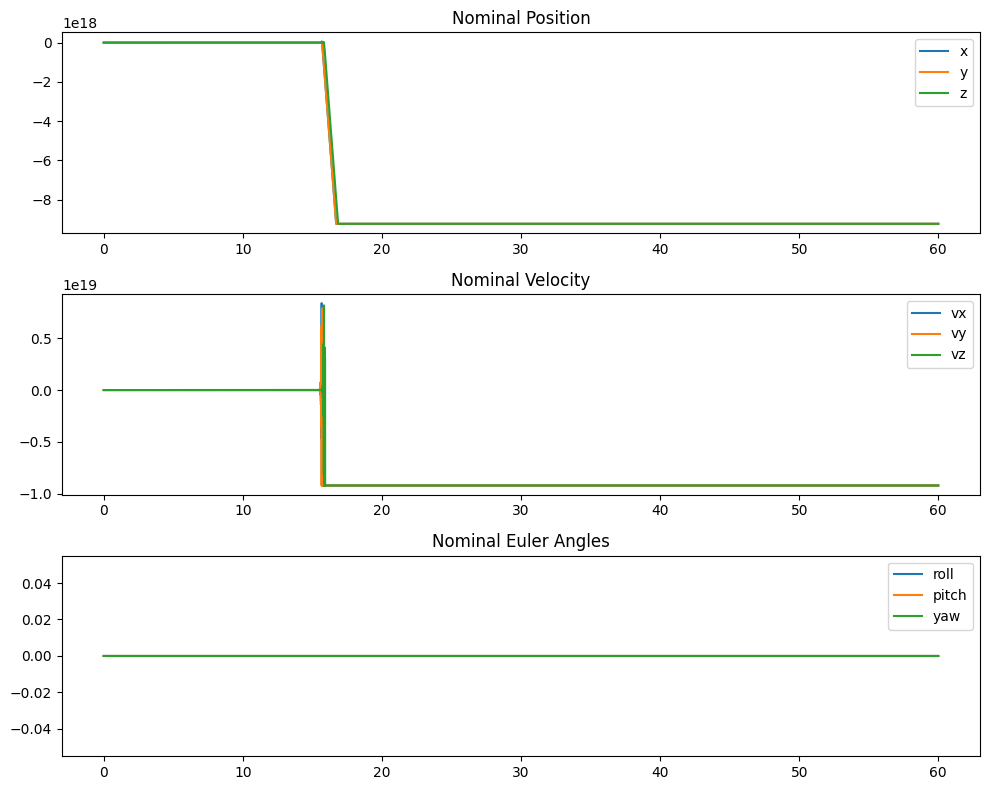

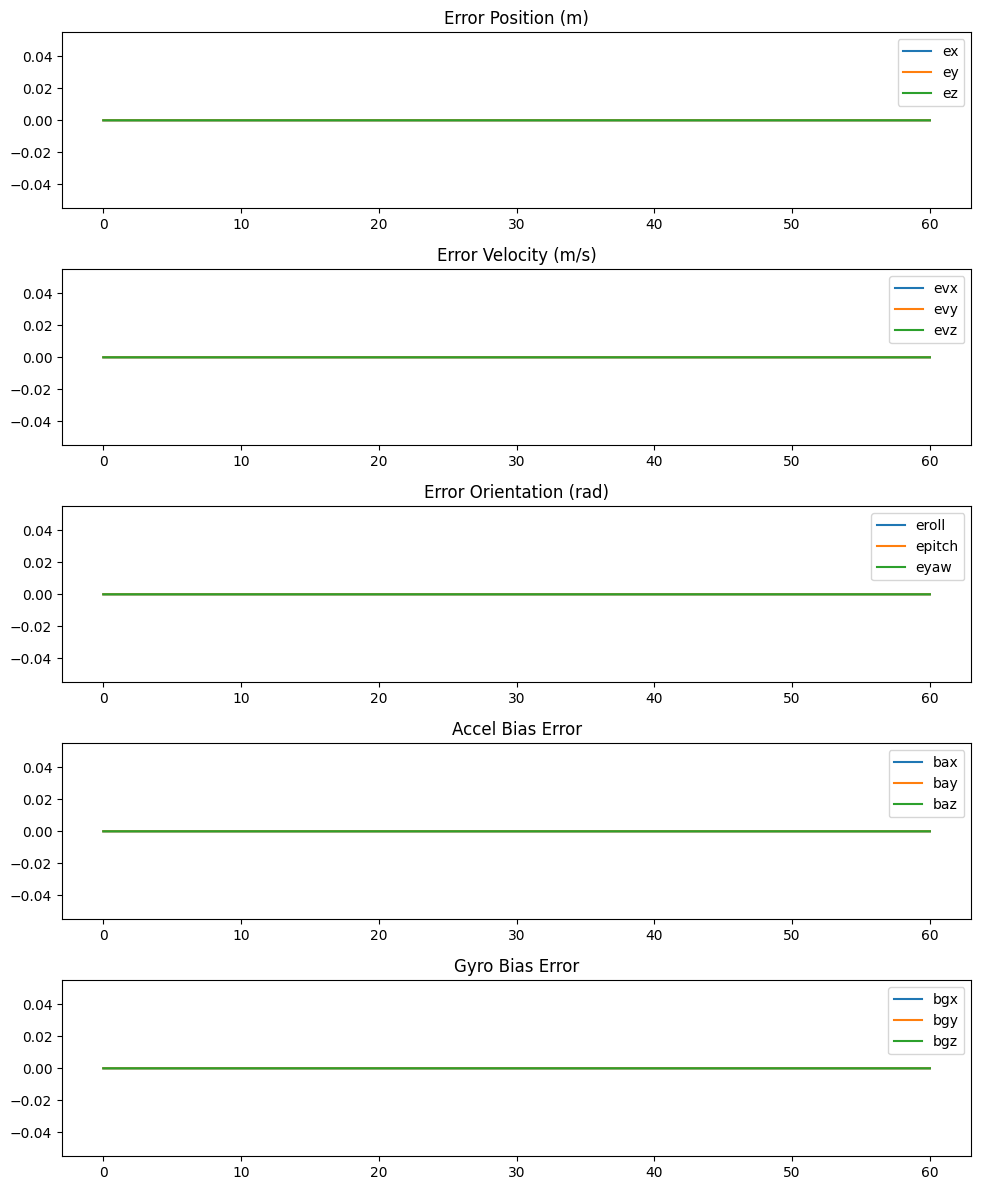

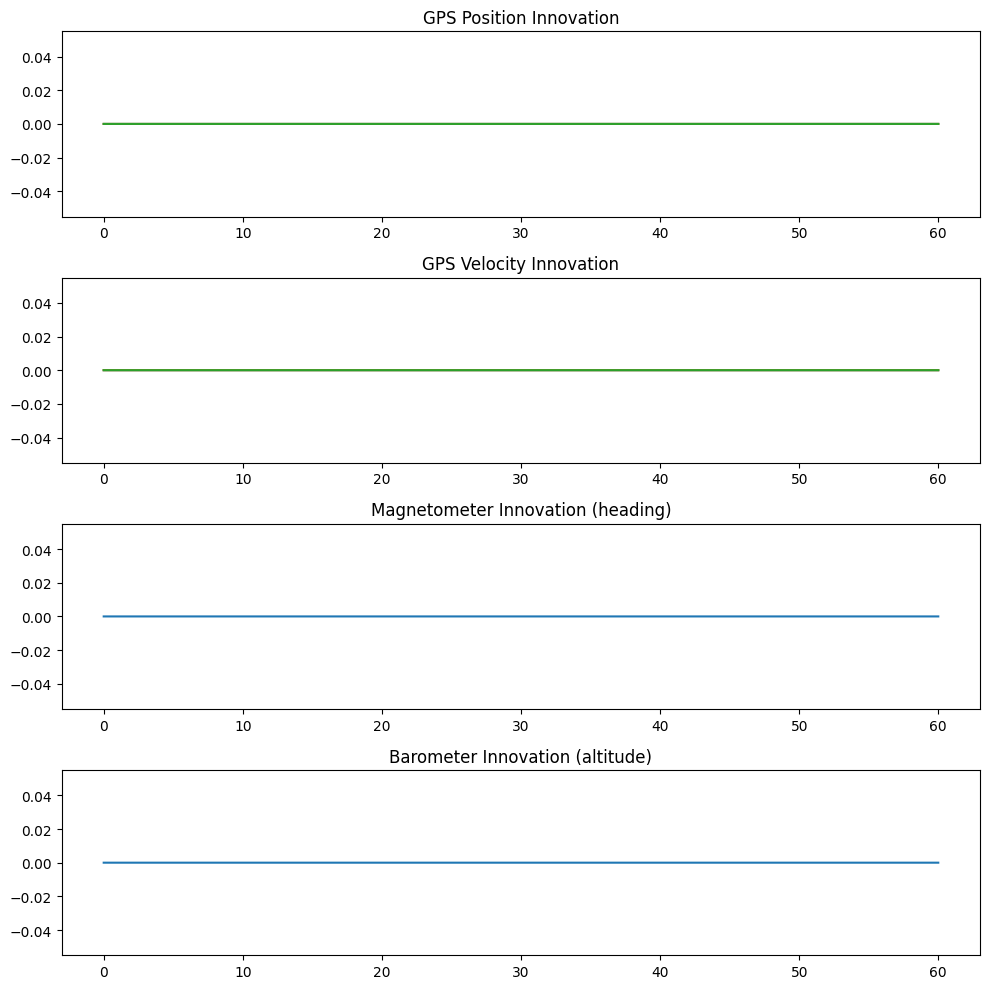

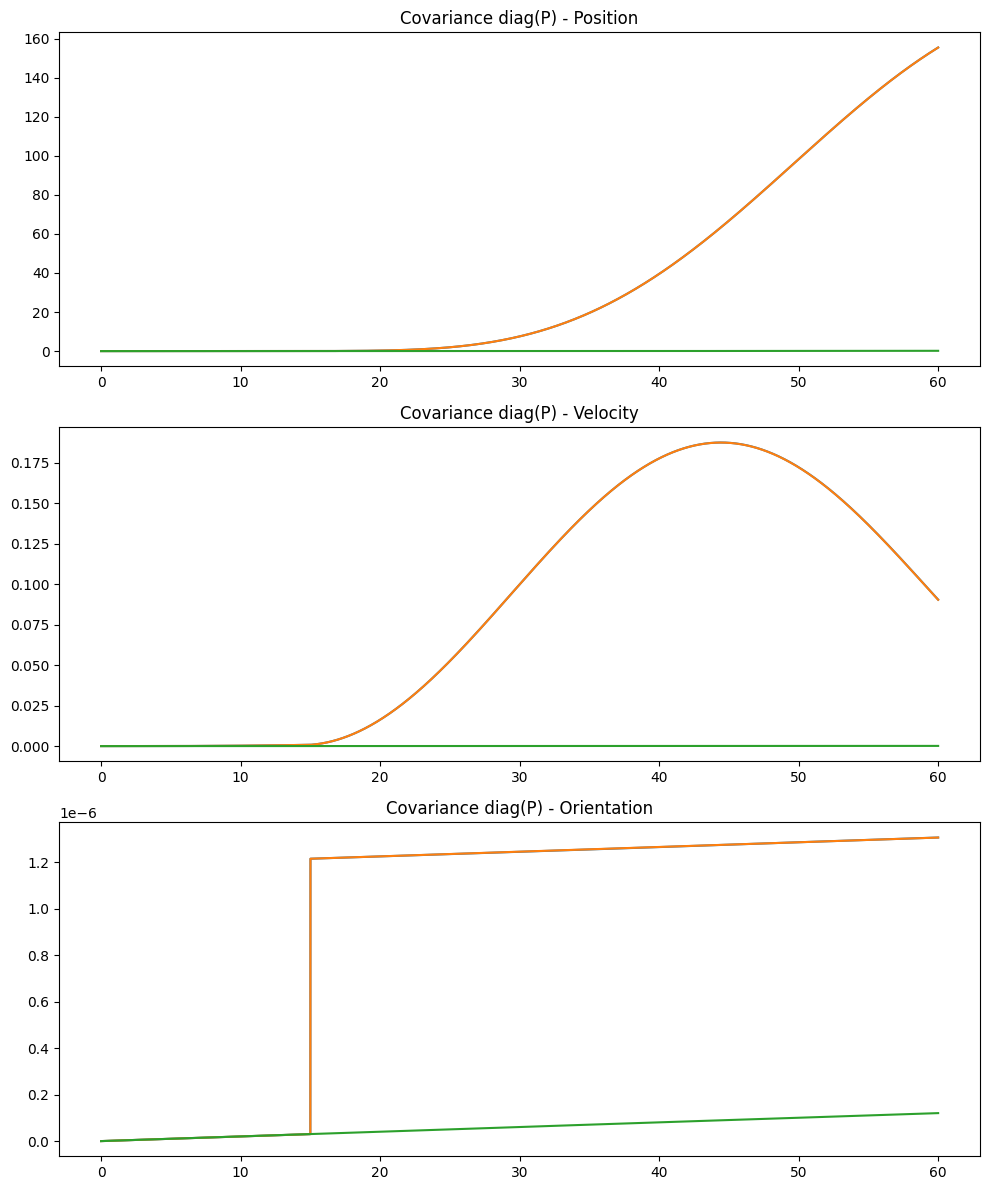

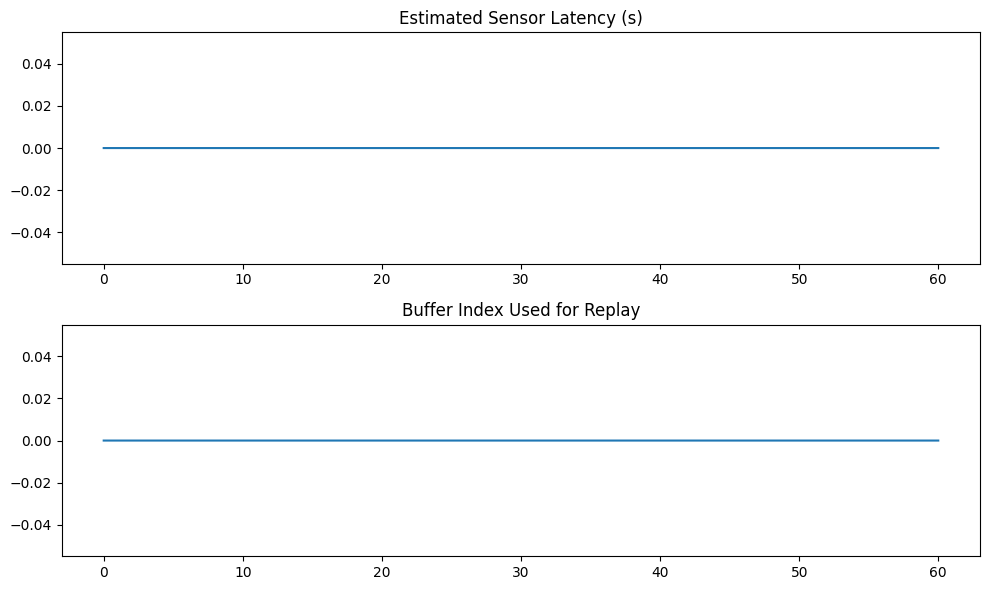

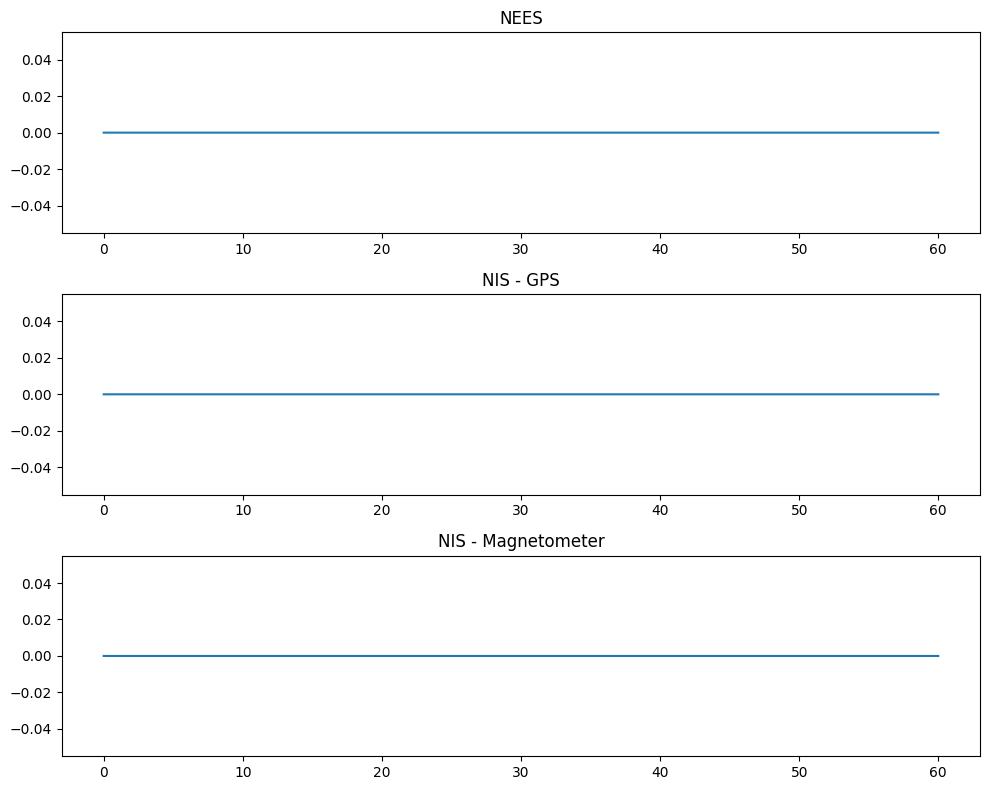

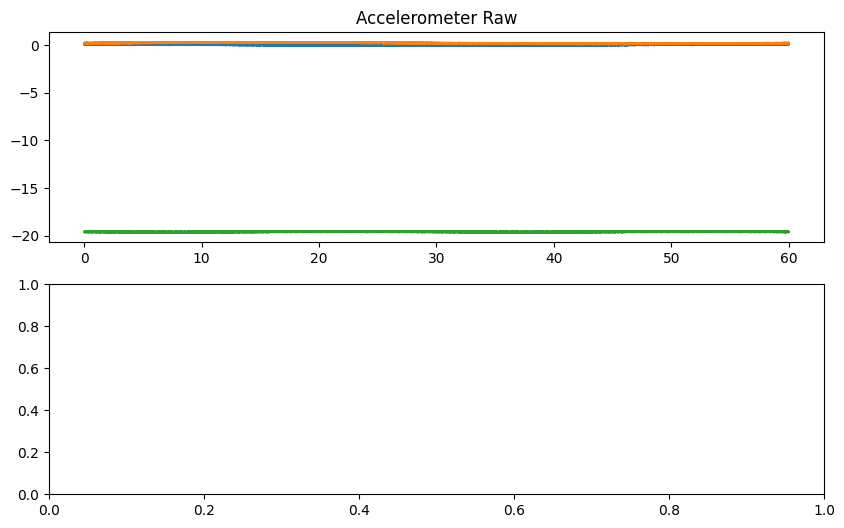

In [7]:

x_0 = np.array([0,0,0, 0,0,0, 1,0,0,0, 0,0,0, 0,0,0]).transpose() 

imu_sample_freq = 500
gps_sample_freq = 10
tf_s = 60 # t final step in second
dt = 1/imu_sample_freq # time step

t_s = np.arange(0, tf_s, dt)    #time step
nt_s = t_s.size                 #number of timestep

x = np.empty((16, nt_s), dtype=float)

x[:,0] = x_0

ekf = EKF(dt)

df = pd.read_csv("data/sim_imu.csv")
gyro = np.vstack([df['gx'], df['gy'], df['gz']])   # shape (3, N)
acc  = np.vstack([df['ax'], df['ay'], df['az']])   # shape (3, N)
print(gyro)

for i in range(nt_s):

    gyro_meas = gyro[:, i]     # shape (3,)
    acc_meas = acc[:, i]      # shape (3,)
    print(gyro_meas)
    x_predicted, p = ekf.predict(gyro_meas, acc_meas,dt, t_s[i])

    euler = tools.quat_to_euler(x_predicted[6:10])

    x[:,i] = x_predicted

# Converti liste → array
def arr(x): return np.array(x)
visualizer.debug_ekf_plots(
    arr(ekf.log["t"]),
    arr(ekf.log["nominal_pos"]),
    arr(ekf.log["nominal_vel"]),
    arr(ekf.log["nominal_euler"]),
    arr(ekf.log["error_pos"]),
    arr(ekf.log["error_vel"]),
    arr(ekf.log["error_att"]),
    arr(ekf.log["error_ba"]),
    arr(ekf.log["error_bg"]),
    arr(ekf.log["Pdiag"]),
    np.zeros((nt_s,3)),       # mag
    np.zeros((nt_s,3)),       # baro
    np.zeros((nt_s,1)),       # mag
    np.zeros((nt_s,1)),       # baro
    np.zeros(nt_s),           # nees
    np.zeros(nt_s),           # nis gps
    np.zeros(nt_s),           # nis mag
    np.zeros(nt_s),           # nis baro
    arr(ekf.log["imu_acc"]),
    arr(ekf.log["imu_gyro"]),
    arr(ekf.log["delay_latency"]),
    arr(ekf.log["delay_index"])
)